## Data 612- Project-4
#### Team: Wei Zhou / Mia Chen

Recommender Systems Accuracy
1. As in your previous assignments, compare the accuracy of at least two recommender system algorithms against your offline data.
2. Implement support for at least one business or user experience goal such as increased serendipity, novelty, or diversity.
3. Compare and report on any change in accuracy before and after you’ve made the change in #2.
4. As part of your textual conclusion, discuss one or more additional experiments that could be performed and/or metrics that could be evaluated only if online evaluation was possible. Also, briefly propose how you would design a reasonable online evaluation environment.

In [2]:
import pandas as pd 
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Read Movie Rating Data

In [5]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']

users=pd.read_csv('ml-100k/u.user',encoding="ISO-8859-1", sep='|',names=u_cols)
ratings = pd.read_csv('ml-100k/u.data',encoding="ISO-8859-1", sep='\t', names=r_cols)
movies = pd.read_csv('ml-100k/u.item', encoding="ISO-8859-1", sep='|', names=m_cols, usecols=range(5))
movielens=pd.merge(users,ratings)
movielens=pd.merge(movielens,movies)
movielens.head(3)


,user_id,age,sex,occupation,zip_code,movie_id,rating,timestamp,title,release_date,video_release_date,imdb_url
0,1,24,M,technician,85711,61,4,878542420,Three Colors: White (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Trzy%20kolory...
1,13,47,M,educator,29206,61,4,882140552,Three Colors: White (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Trzy%20kolory...
2,18,35,F,other,37212,61,4,880130803,Three Colors: White (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Trzy%20kolory...


### Understand Movie Rating Data

In [6]:
movielens.shape


(100000, 12)

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

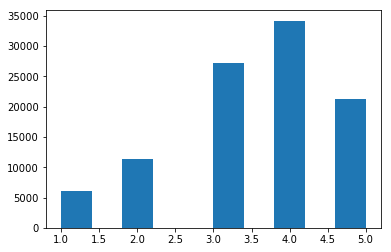

In [7]:
plt.hist(movielens["rating"])


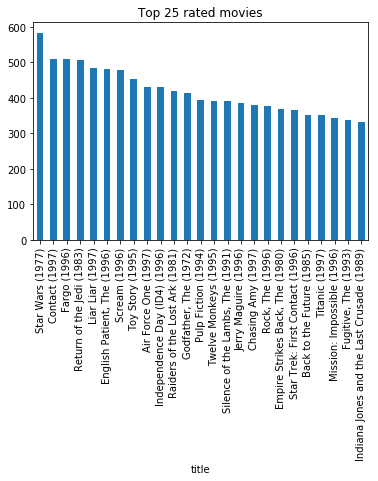

In [9]:
top_rated=movielens.groupby('title').size().sort_values(ascending=False)[:25]
top_rated.plot(kind="bar",title="Top 25 rated movies",label="count")

In order to put popularity as a measurment.  So we choose a szie of 200 and check the results.

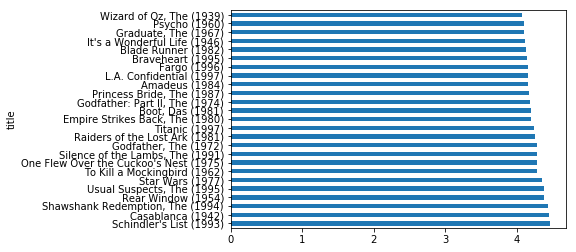

In [11]:
movie_stat = movielens.groupby('title').agg({'rating':[np.size,np.mean]})
most200=movie_stat['rating']['size'] >= 200
most_rated_mean=movie_stat[most200].sort_values([('rating', 'mean')], ascending=False)
most_rated_mean['rating']['mean'].sort_values(ascending=False)[:25].plot(kind="barh")


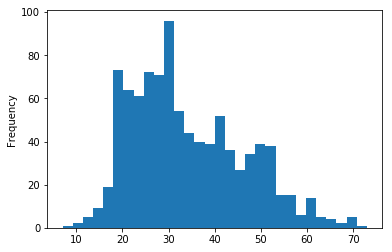

In [12]:
users.age.plot.hist(bins=30)
plt.xlabel=("Age")
plt.ylabel=("count")
plt.title=("Age distribution")

### RECOMMENDER ENGINE 

1: Collaborative Filtering User based


In [13]:

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

movielens.drop(movielens.columns[[3,4,7]], axis=1, inplace=True)
ratings.drop( "timestamp", inplace = True, axis = 1 ) 
movies.drop(movies.columns[[3,4]], inplace = True, axis = 1 )
#Dropping all the columns that are not really needed
movielens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
user_id               100000 non-null int64
age                   100000 non-null int64
sex                   100000 non-null object
movie_id              100000 non-null int64
rating                100000 non-null int64
title                 100000 non-null object
release_date          99991 non-null object
video_release_date    0 non-null float64
imdb_url              99987 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 10.1+ MB


In [14]:
movie_stats = movielens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

In [15]:
#Setting a threshold of atleast 50 ratings for better analysis.
min_50 = movie_stats['rating']['size'] >= 50
movie_stats[min_50].sort_values([('rating', 'mean')], ascending=False).head()


rating          
                                                     size      mean
title                                                              
Close Shave, A (1995)                                 112  4.491071
Schindler's List (1993)                               298  4.466443
Wrong Trousers, The (1993)                            118  4.466102
Casablanca (1942)                                     243  4.456790
Wallace & Gromit: The Best of Aardman Animation...     67  4.447761

In [16]:

#pivot table
ratings_matrix = ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True )
ratings_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#Cosine similarity
movie_similarity = 1 - pairwise_distances( ratings_matrix.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix = pd.DataFrame( movie_similarity )
ratings_matrix.head(5)

/Users/zhouw/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,0.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,0.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,0.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,0.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


In [29]:
#Recommender Engine
def recomm_engine1(user_inp,n=10):
    try:
        #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
#         user_inp="Speed (1994)"
        inp=movies[movies['title']==user_inp].index.tolist()
        inp=inp[0]

        movies['similarity'] = ratings_matrix.iloc[inp]
        movies.columns = ['movie_id', 'title', 'release_date','similarity']
        return movies.sort_values( ["similarity"], ascending = False )[1:n]
    except:
        print("Sorry, the movie is not in the database!")

In [30]:
recomm_engine1('Speed (1994)')

,movie_id,title,release_date,similarity
384,385,True Lies (1994),01-Jan-1994,0.719504
160,161,Top Gun (1986),01-Jan-1986,0.707567
78,79,"Fugitive, The (1993)",01-Jan-1993,0.696583
95,96,Terminator 2: Judgment Day (1991),01-Jan-1991,0.695556
194,195,"Terminator, The (1984)",01-Jan-1984,0.676778
173,174,Raiders of the Lost Ark (1981),01-Jan-1981,0.676664
209,210,Indiana Jones and the Last Crusade (1989),01-Jan-1989,0.674811
549,550,Die Hard: With a Vengeance (1995),01-Jan-1995,0.674143
203,204,Back to the Future (1985),01-Jan-1985,0.665776


### RECOMMEND ENGINE 2: 
2. Matrix Facterization Recommendation Systerm


In [33]:
print(ratings.shape)  # 100K entries
user_count = len(set(ratings['user_id'])) # should be 943 users
print(user_count)
movie_count = len(set(ratings['movie_id']))  # should be 1682 movies
print(movie_count)

(100000, 3)
943
1682


In [37]:
#Exclude those movies have less than 10% of users given ratings

users_per_mov = ratings['movie_id'].value_counts()
mov_list = users_per_mov[users_per_mov > (user_count * 0.1)]
data_mov = ratings[ratings['movie_id'].isin(mov_list.index)]

In [38]:
#Create User-Item-Rating Matrix (COO_matrix)
from scipy.sparse import coo_matrix
R = coo_matrix((data_mov['rating'].astype('float'),
                (data_mov['user_id']-1, data_mov['movie_id']-1)))

In [39]:
#Training Set: all Rui's > 0 since 0 means no rating
#Loss Function: Root Mean Square Error (RMSE) with regularization between Actual and Predicted Rui's
#Optimization Function: Stochastic Gradient Descent (SGD)
#Training Outcome: To adjust P and Q until RMSE < 0.5 or epoch = 10, whichever comes earlier

# this function will return the error between the actual rating and the ratings calculated from P and Q matrices
# predicted rating is calculated using the formula 
# pow(rui-np.dot(P[u,:],Q[:,i]),2)+ lamda*(pow(norm(P[u,:]),2)+pow(norm(Q[:,i]),2
from numpy.linalg import norm
import numpy as np
def error(R,P,Q,reg=0.02):
    ratings = R.data
    rows = R.row
    cols = R.col
    e = 0 
    # go through every rating 
    for ui in range(len(ratings)): # Only non-zero ratings are considered as elements in the ratings vector
        # Save the rating, user code and movie code
        rui=ratings[ui]
        u = rows[ui]
        i = cols[ui]
        if rui>0:
            # Find the sum of errors
            e= e + pow(rui-np.dot(P[u,:],Q[:,i]),2)+\
                reg*(pow(norm(P[u,:]),2)+pow(norm(Q[:,i]),2))
    return e

In [40]:
# Function that will calculate P and Q matrices using stochastic gradient descent
def SGD(R, K, reg=0.02,steps=10, lrate=0.001):
    # Initialise the P and Q Factor Matrices with random numbers
    # Setup the dimensions 
    # M - No. of users
    # N - No. of items
    # K - No. of features
    sigma = 0.1
    M,N = R.shape
    P = np.random.rand(M,K) * sigma
    Q = np.random.rand(K,N) * sigma
    
    # calculate the initial RMSE
    rmse = np.sqrt(error(R,P,Q,reg)/len(R.data))
    print("Initial RMSE:" + str(rmse))
    
    # complete the specified number of steps for gradient descent
    for step in range(steps):
        # complete the specified number of steps for gradient descent 
        for ui in range(len(R.data)):
            rui=R.data[ui]
            u = R.row[ui]
            i = R.col[ui]
            if rui>0:
                # update P, Q in the direction of local minima
                eui=rui-np.dot(P[u,:],Q[:,i])
                P[u,:]=P[u,:]+lrate*2*(eui*Q[:,i]-reg*P[u,:])
                Q[:,i]=Q[:,i]+lrate*2*(eui*P[u,:]-reg*Q[:,i])
        rmse = np.sqrt(error(R,P,Q,reg)/len(R.data))
        print(step, rmse)
        if rmse<0.5:
            break
    print("Final RMSE: "+ str(rmse))
    return P,Q

In [41]:
# call the SGD to calculate P,Q
(P,Q)=SGD(R,K=2,lrate=0.0007,reg=0.01, steps=100)

Initial RMSE:3.8397360738113284
(0, 3.8164013126966174)
(1, 3.697746020584139)
(2, 3.223855311449597)
(3, 2.3399859173351056)
(4, 1.7374116339682795)
(5, 1.4290949139620106)
(6, 1.2521451728622648)
(7, 1.1461406984957447)
(8, 1.0810486228455773)
(9, 1.0400826181164962)
(10, 1.0136128818890089)
(11, 0.9960396682736107)
(12, 0.9840620757962064)
(13, 0.9756985962673568)
(14, 0.9697321475938009)
(15, 0.965395618554415)
(16, 0.9621925179971232)
(17, 0.9597932161082695)
(18, 0.9579736908674826)
(19, 0.9565784916623574)
(20, 0.9554977677472816)
(21, 0.95465265463896)
(22, 0.9539857511711262)
(23, 0.9534547751770289)
(24, 0.9530282519633118)
(25, 0.9526825320978669)
(26, 0.9523996963213137)
(27, 0.9521660633791388)
(28, 0.9519711143236935)
(29, 0.9518067086626026)
(30, 0.9516665076475735)
(31, 0.9515455462593616)
(32, 0.9514399130217521)
(33, 0.9513465087242309)
(34, 0.9512628633666524)
(35, 0.9511869963849122)
(36, 0.9511173092711758)
(37, 0.9510525025920616)
(38, 0.9509915114876266)
(39, 0.9

In [42]:
# call the SGD to calculate P,Q
(P,Q)=SGD(R,K=20,lrate=0.0007,reg=0.01, steps=100)

Initial RMSE:3.7971990170178036
(0, 3.5929276502952856)
(1, 2.899774111699805)
(2, 1.9895758880267176)
(3, 1.5188893309867164)
(4, 1.2880522309841673)
(5, 1.1600495326477986)
(6, 1.0857164010378302)
(7, 1.040929964414302)
(8, 1.01294587457758)
(9, 0.9948304108268299)
(10, 0.9827100621846728)
(11, 0.9743577618662047)
(12, 0.9684520101495058)
(13, 0.9641824111847777)
(14, 0.9610356563728368)
(15, 0.9586766398685095)
(16, 0.9568805709982672)
(17, 0.9554930281407954)
(18, 0.9544057245858392)
(19, 0.953541364780651)
(20, 0.9528439166647394)
(21, 0.9522722053015831)
(22, 0.9517955994460122)
(23, 0.9513910503434075)
(24, 0.9510410240085952)
(25, 0.9507320356983286)
(26, 0.9504535973871321)
(27, 0.9501974528448757)
(28, 0.9499570156833791)
(29, 0.9497269523358671)
(30, 0.949502869609528)
(31, 0.9492810783946818)
(32, 0.9490584133063097)
(33, 0.9488320937280372)
(34, 0.9485996157385599)
(35, 0.9483586672559241)
(36, 0.9481070607946136)
(37, 0.9478426797326199)
(38, 0.9475634350970471)
(39, 0.94

In [43]:
# call the SGD to calculate P,Q
(P,Q)=SGD(R,K=40,lrate=0.0007,reg=0.01, steps=100)

Initial RMSE:3.748749616828331
(0, 3.3704999189001548)
(1, 2.43884269645365)
(2, 1.68811829810667)
(3, 1.3603445618891359)
(4, 1.1948731514313278)
(5, 1.1033036231820523)
(6, 1.0501652888495405)
(7, 1.0179539300003002)
(8, 0.9975999407394486)
(9, 0.9842366096988914)
(10, 0.9751587032909421)
(11, 0.9688063850723212)
(12, 0.9642462083992838)
(13, 0.9608990126395104)
(14, 0.9583931466881086)
(15, 0.9564827910828307)
(16, 0.9550009856056758)
(17, 0.9538317023870193)
(18, 0.9528926989917788)
(19, 0.9521246692185829)
(20, 0.9514841891084331)
(21, 0.9509390183412226)
(22, 0.9504649035028702)
(23, 0.9500433625502366)
(24, 0.949660124241283)
(25, 0.949304013085732)
(26, 0.9489661423870678)
(27, 0.9486393234465255)
(28, 0.9483176283905949)
(29, 0.9479960634531653)
(30, 0.9476703225398662)
(31, 0.9473365997683446)
(32, 0.9469914458173404)
(33, 0.9466316572308802)
(34, 0.9462541908971009)
(35, 0.9458560981418884)
(36, 0.9454344745050975)
(37, 0.9449864224782158)
(38, 0.9445090253943695)
(39, 0.943

In [44]:
# call the SGD to calculate P,Q
(P,Q)=SGD(R,K=100,lrate=0.005,reg=0.02, steps=20)


Initial RMSE:3.6058636911839765
(0, 1.0584590954063948)
(1, 1.0095187986375682)
(2, 1.0030801567541712)
(3, 0.9996518964673937)
(4, 0.9957145030299139)
(5, 0.990047011755634)
(6, 0.9816400508199499)
(7, 0.9700315755827835)
(8, 0.9559626667171621)
(9, 0.940583898889892)
(10, 0.9241398075749963)
(11, 0.9064323125284668)
(12, 0.8876598894198946)
(13, 0.8684007146187352)
(14, 0.8492766573893858)
(15, 0.8307696693574878)
(16, 0.8132071179261183)
(17, 0.7967944683606293)
(18, 0.7816416582418753)
(19, 0.7677843250885765)
Final RMSE: 0.7677843250885765
